<a href="https://colab.research.google.com/github/ernestojr-7/kaggle_raioX/blob/main/Kaggle_raioX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)
main_dir = '/content/drive/MyDrive/datasets/COVID-19_Radiography_Dataset'
os.chdir(main_dir)

Mounted at /content/drive


[Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database)

#Imports

In [2]:
from PIL import Image,ImageStat
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

import torchvision
import torch
import torch.nn as nn
from torch.utils.data import  DataLoader
import torchvision.transforms as transforms
import torch.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics

import json
import random
from tqdm.notebook import tqdm
import time

#funções auxiliares

In [3]:
def carrega_imagem(imagem):
  return Image.open(imagem)

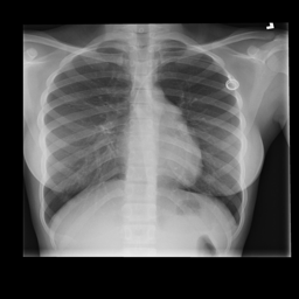

In [4]:
carrega_imagem('Normal/Normal-1.png')

In [5]:
# funcao para salvar os parametros de validacao em json
def save_data_json(path, name_model, file_name, l_metrics, l_names):
    exist = os.path.exists(f'{path}{file_name}.json')
    if not exist:
        data = dict()
    else:
        f = open(f'{path}{file_name}.json')
        data = json.load(f)
    data[name_model] = dict()
    for i, x in enumerate(l_names):
      data[name_model][x] = l_metrics[i]
    with open(f'{path}{file_name}.json', 'w') as json_file:
        json.dump(data, json_file)
    return data

In [6]:
# plotar graficos da loss e acc por epoca
def plot_acc_loss(name_model, l_epoca, l_loss, l_acc):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
    ax1.plot(l_epoca, l_loss)
    ax1.set_xlabel('Epoca')
    ax1.set_ylabel('Loss')

    ax2.plot(l_epoca, l_acc)
    ax2.set_xlabel('Epoca')
    ax2.set_ylabel('Acc')

    plt.show();
    plt.savefig(f'{name_model}.png')

In [7]:
def plot_confusion_matrix(pred_list, rotulo_list, labels_list = None):
    cm = metrics.confusion_matrix(rotulo_list, pred_list)
    ax = sn.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False);
    if labels_list is not None:
      ax.xaxis.set_ticklabels(labels_list)
      ax.yaxis.set_ticklabels(labels_list, rotation=45)
    plt.title("MATRIX DE CONFUSÃO")
    plt.xlabel("classificação predita")
    plt.ylabel("classificação real")
    plt.show()

In [8]:
def view_test(model, ds_test, criterion, name_model, l_labels):
    # Teste
    dl_test  = torch.utils.data.DataLoader(ds_test,batch_size =args['batch_size'])
    test_loss, test_acc, l_true, l_pred = validate(dl_test, model, criterion)   
    l_metrics = []
    l_metrics.append(test_loss)
    l_metrics.append(test_acc)
    l_names = ['test_loss', 'test_acc']
    save_data_json('./', name_model, 'Testes', l_metrics, l_names)
    # Metricas
    rec = metrics.recall_score(l_true, l_pred, average='macro')
    f_1 = metrics.f1_score(l_true, l_pred,average='macro') 
    prec = metrics.precision_score(l_true, l_pred,average='macro',zero_division=1)

    print("Accuracy Teste:   ",np.mean(test_acc))
    print("Recall Score:     ", rec)
    print("Precission Score: ", prec)
    print("F1:               ",f_1)
    print("Loss Teste:       ",np.mean(test_loss))    
    plot_confusion_matrix(l_true, l_pred, l_labels)

In [9]:
# classificar uma img
def classifier_img(image_path, model, transform, classes):
   device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
   img = Image.open(image_path)
   img_normalized = transform(img).float()
   img_normalized = img_normalized.unsqueeze_(0)
   img_normalized = img_normalized.to(device)
   with torch.no_grad():
      model.eval()  
      pred = model(img_normalized)
      index = pred.data.cpu().numpy().argmax()
      name = classes[index]
      return index, name

In [20]:
!pip install torchcam

In [24]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchcam.methods import SmoothGradCAMpp
from torchcam.methods import GradCAM, XGradCAM
from torchcam.utils import overlay_mask

def grad_cam_img(model, transform, path_img, l_layer):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    cam_extractor = XGradCAM(model, target_layer=l_layer)
    img = Image.open(path_img).convert('RGB')
    input_tensor = transform(img).float()
    out = model(input_tensor.unsqueeze(0).to(device))
    activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
    result = overlay_mask( img, to_pil_image(activation_map[0], mode='F'), alpha=0.5)
    # plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()
    return result

#Carregamento Dataset

In [12]:
# retorna lista de tuplas no formato [(path_img0, label_img0), ...]
def make_instances(dir, samples2class=None):
        instances = []
        cont = 0
        cont_class = 0
        instances = []
        classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        for target_class in sorted(class_to_idx.keys()):
                class_index = class_to_idx[target_class]
                target_dir = os.path.join(dir, target_class)
                for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
                    for fname in sorted(fnames):
                        path = os.path.join(root, fname)
                        item = path, class_index
                        if samples2class is not None:
                            # seleciona sample_class imagens de cada classe
                            if cont < samples2class and class_index == cont_class:
                              instances.append(item)
                              cont += 1
                            else:
                              cont = 0
                              cont_class += 1
                              break
                        else:
                            instances.append(item)
        # embaralha lista de instances 
        random.seed(22)                 
        random.shuffle(instances)
        return instances

In [13]:
# carrega Dataset
from torch.utils.data import Dataset

from typing import Any,Tuple

class RaioXDataset(Dataset):
    def __init__(self, instances, transform=None,target_transform=None,loader = None):
        self.transform = transform
        self.target_transform = target_transform
        self.instances = instances
        self.loader = loader
        if loader is None:
            self.loader = lambda x: Image.open(x)

    def __getitem__(self,index:int) -> Tuple[Any,Any]:
        path, target = self.instances[index]
        instance = self.loader(path)
        if self.transform is not None:
            instance = self.transform(instance)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return instance,target

    def __len__(self) -> int:
        return len(self.instances)


In [14]:
# dataset transformation
transform = transforms.Compose([transforms.Grayscale(num_output_channels=3),
                                transforms.Resize((300,300)),
                                transforms.ToTensor(),
                                # transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                    std=[0.229, 0.224, 0.225])
                            ])

In [15]:
# Configurando hiperparâmetros.
args = {
    'lr': 1e-2,           # Taxa de aprendizado.
    'weight_decay': 1e-3, # Penalidade L2 (Regularização).
    'batch_size': 8,     # Tamanho do batch.
}

# Definindo dispositivo de hardware
if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cuda


#Rotinas de treino, validação

In [16]:
def train(train_loader, model, criterion, optimizer):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  # Training mode
  model.to(device)
  model.train()

  lloss  = []
  lacc = []
  l_pred, l_true = [], []
  for _, batch in enumerate(tqdm(train_loader)):
    # dado = x e rotulo = y
    dado, rotulo = batch
    
    # Cast do dado na GPU
    dado = dado.to(device)
    rotulo = rotulo.to(device)
    
    # Forward
    pred = model(dado)
    loss = criterion(pred, rotulo)
    
    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    lloss.append(loss.item())
          
  # lacc = np.asarray(lacc)
  # lloss = np.asarray(lloss)
  # pred_list  = np.asarray(l_pred).ravel()
  # rotulo_list  = np.asarray(l_true).ravel()
  
  # print('______________________________________________________________')
  # print(f'Epoch {epoch}, TRAIN ---> Loss: {np.mean(lloss)})')
  # # print('______________________________________________________________')
  return np.mean(lloss)

In [17]:
def validate(val_loader, model, criterion):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
  # Evaluation mode
  model.to(device)
  model.eval()
 
  lloss  = []
  lacc = []
  lprec, lrec = [], []
  l_pred, l_true = [], []
  with torch.no_grad(): 
    for _, batch in enumerate(tqdm(val_loader)):

        # dado = x e rotulo = y
        dado, rotulo = batch
        
        # Cast do dado na GPU
        dado = dado.to(device)
        rotulo = rotulo.to(device)
        
        # Forward
        pred = model(dado)
        loss = criterion(pred, rotulo)
        lloss.append(loss.cpu().item())

        y_pred = pred.argmax(dim=1).cpu()         
        l_true = l_true + rotulo.tolist()
        l_pred = l_pred + y_pred.tolist()

        acc = metrics.accuracy_score(rotulo.cpu(),y_pred.cpu())
        lacc.append(acc)
        # prec = metrics.precision_score(rotulo.cpu(), y_pred.cpu(), average='macro')
        # lprec.append(prec)
        # rec = metrics.recall_score(rotulo.cpu(), y_pred.cpu(), average='macro')
        # lrec.append(rec)


  # print('______________________________________________________________')
  # print(f'Epoch {epoch}, VALIDATE ---> Loss: {np.mean(lloss)} +/- {np.std(lloss)}, Acc:{np.mean(lacc)}, Prec: {np.mean(prec)}, Rec: {np.mean(rec)} \n')
  # print('______________________________________________________________')
  
  return np.mean(lloss), np.mean(lacc), l_true, l_pred

#Rotina de treino e validação

In [18]:
def routine_train_validate(model, l_labels, dataset_train, dataset_val, n_epoch, criterion, opt):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # TREINO E VALIDACAO
    model.to(device)  
        
    ultima_acc  = 0.0 
    epoch = 0   

    dl_train = torch.utils.data.DataLoader(dataset_train,batch_size = args['batch_size'], num_workers=2, pin_memory=True)
    dl_val   = torch.utils.data.DataLoader(dataset_val,batch_size = args['batch_size'], num_workers=2, pin_memory=True)
    # dl_test  = torch.utils.data.DataLoader(dataset_test,batch_size =args['batch_size'])

    lepoca = []
    lacc  = []
    lloss = []
    lrec  = []
    lprecision = []

    while epoch < (n_epoch):
        since = time.time()
        # treino
        train_loss = train(dl_train, model, criterion,opt)
        # validacao
        val_loss, val_acc, l_true, l_pred = validate(dl_val, model, criterion)

        lepoca.append(epoch)
        lacc.append(val_acc)
        lloss.append(val_loss)
        lprecision.append(metrics.precision_score(l_true, l_pred,average='macro',zero_division=1))
        lrec.append(metrics.recall_score(l_true, l_pred, average='macro'))

        epoch+=1

        print("Epoch:{}/{}..".format(epoch+1, n_epoch),
              "Train Loss: {:.3f}..".format(train_loss),
              "Val Loss: {:.3f}..".format(val_loss),
              "Val Acc:{:.3f}..".format(val_acc),
              "Val Prec:{:.3f}..".format(metrics.precision_score(l_true, l_pred,average='macro',zero_division=1)),
              "Val Rec:{:.3f}..".format( metrics.recall_score(l_true, l_pred, average='macro')),
              "Time: {:.2f}m".format((time.time()-since)/60))
        # definir criterio de parada

    finalResultsMeans = {"Acc": np.mean(lacc), "Prec": np.mean(lprecision), "Rec": np.mean(lrec), "Loss": np.mean(lloss)}
    print("\n---------------------------------------Final Results---------------------------------------")
    print("Mean: ", finalResultsMeans)
    plot_confusion_matrix(l_true, l_pred, l_labels)
    return lepoca, lloss, lacc

#Comparativo entre modelos

In [20]:
dataset = make_instances(main_dir, 500)
len(dataset)

2000

In [21]:
# treino 70% teste 15% validacao 15%
dataset_train, dataset_aux= train_test_split(dataset, test_size = 0.30, shuffle = True, random_state=21)
dataset_val, dataset_test = train_test_split(dataset_aux, test_size = 0.50, shuffle = True, random_state=21)

In [22]:
ds_train = RaioXDataset(dataset_train, transform=transform)
ds_val = RaioXDataset(dataset_val, transform=transform)
ds_test = RaioXDataset(dataset_test, transform=transform)

In [23]:
print(len(ds_train), len(ds_val), len(ds_test))

1400 300 300


In [24]:
l_labels = ['COVID', 'Lung Opacity', 'Normal', 'Viral Pneumonia']

##ResNet18

In [ ]:
name_model = 'resnet18'
model = torchvision.models.resnet18(pretrained=True)
criterion = nn.CrossEntropyLoss().to(args['device'])
# optimizer = optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=0.9)

In [ ]:
# ajuste da ultima camada
model.fc = nn.Linear(512,4)

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:2/15.. Train Loss: 0.623.. Val Loss: 0.383.. Val Acc:0.872.. Val Prec:0.883.. Val Rec:0.872.. Time: 7.75m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:3/15.. Train Loss: 0.313.. Val Loss: 0.257.. Val Acc:0.931.. Val Prec:0.935.. Val Rec:0.929.. Time: 0.60m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:4/15.. Train Loss: 0.147.. Val Loss: 0.152.. Val Acc:0.951.. Val Prec:0.951.. Val Rec:0.951.. Time: 0.60m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:5/15.. Train Loss: 0.062.. Val Loss: 0.133.. Val Acc:0.954.. Val Prec:0.953.. Val Rec:0.954.. Time: 0.60m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:6/15.. Train Loss: 0.038.. Val Loss: 0.137.. Val Acc:0.954.. Val Prec:0.954.. Val Rec:0.954.. Time: 0.60m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:7/15.. Train Loss: 0.019.. Val Loss: 0.139.. Val Acc:0.961.. Val Prec:0.961.. Val Rec:0.961.. Time: 0.60m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:8/15.. Train Loss: 0.008.. Val Loss: 0.140.. Val Acc:0.954.. Val Prec:0.954.. Val Rec:0.954.. Time: 0.60m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:9/15.. Train Loss: 0.006.. Val Loss: 0.128.. Val Acc:0.964.. Val Prec:0.964.. Val Rec:0.964.. Time: 0.60m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:10/15.. Train Loss: 0.004.. Val Loss: 0.124.. Val Acc:0.964.. Val Prec:0.964.. Val Rec:0.964.. Time: 0.60m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:11/15.. Train Loss: 0.004.. Val Loss: 0.123.. Val Acc:0.964.. Val Prec:0.964.. Val Rec:0.964.. Time: 0.60m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:12/15.. Train Loss: 0.003.. Val Loss: 0.122.. Val Acc:0.961.. Val Prec:0.961.. Val Rec:0.961.. Time: 0.60m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:13/15.. Train Loss: 0.003.. Val Loss: 0.121.. Val Acc:0.961.. Val Prec:0.961.. Val Rec:0.961.. Time: 0.60m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:14/15.. Train Loss: 0.003.. Val Loss: 0.120.. Val Acc:0.961.. Val Prec:0.961.. Val Rec:0.961.. Time: 0.61m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:15/15.. Train Loss: 0.002.. Val Loss: 0.120.. Val Acc:0.961.. Val Prec:0.961.. Val Rec:0.961.. Time: 0.60m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:16/15.. Train Loss: 0.002.. Val Loss: 0.119.. Val Acc:0.961.. Val Prec:0.961.. Val Rec:0.961.. Time: 0.61m

---------------------------------------Final Results---------------------------------------
Mean:  {'Acc': 0.9513157894736844, 'Prec': 0.9524850287176131, 'Rec': 0.9511186794081529, 'Loss': 0.1546505474082088}


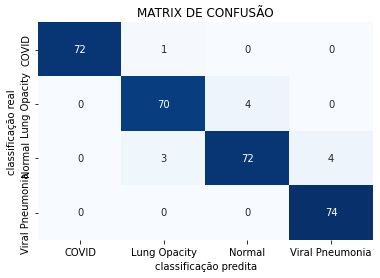

In [ ]:
l_epoca, l_loss, l_acc = routine_train_validate(model, l_labels, ds_train, ds_val, 15, criterion, optimizer)

In [ ]:
l_metrics = []
l_metrics.append(l_loss)
l_metrics.append(l_acc)
l_names = ['val_loss', 'val_acc']
save_data_json('./', name_model, 'Data', l_metrics, l_names)

{'resnet18': {'val_acc': [0.8717105263157895,
   0.930921052631579,
   0.9506578947368421,
   0.9539473684210527,
   0.9539473684210527,
   0.9605263157894737,
   0.9539473684210527,
   0.9638157894736842,
   0.9638157894736842,
   0.9638157894736842,
   0.9605263157894737,
   0.9605263157894737,
   0.9605263157894737,
   0.9605263157894737,
   0.9605263157894737],
  'val_loss': [0.38311372305217545,
   0.257090326447628,
   0.15202542784084616,
   0.13327732046232804,
   0.13708425088368945,
   0.13901122053319245,
   0.14036976329148992,
   0.12806542169020854,
   0.12423332193774465,
   0.1228602283609737,
   0.121844956351101,
   0.12109310206754967,
   0.12038958453922532,
   0.1198610393475974,
   0.11943852431738235]}}

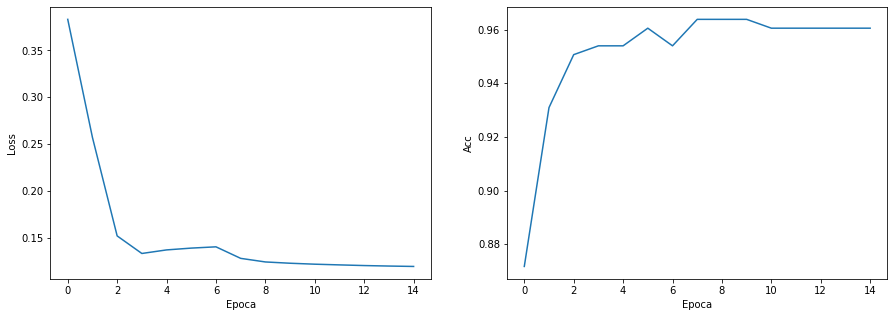

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_acc_loss(name_model, l_epoca, l_loss, l_acc)

Teste

  0%|          | 0/38 [00:00<?, ?it/s]

Accuracy Teste:    0.9539473684210527
Recall Score:      0.9534388856757279
Precission Score:  0.9544307373575667
F1:                0.9533818724025254
Loss Teste:        0.21615763541347788


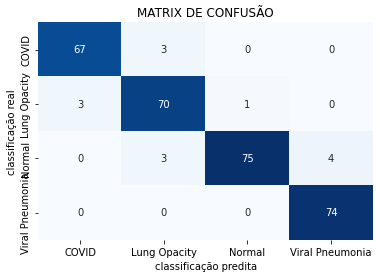

In [ ]:
view_test(model, ds_test, criterion, name_model, l_labels)

##ResNet50

In [ ]:
name_model = 'resnet50'
model = torchvision.models.resnet50(pretrained=True)
criterion = nn.CrossEntropyLoss().to(args['device'])
# optimizer = optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=0.9)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
model.fc = nn.Linear(2048,4)

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:2/15.. Train Loss: 0.639.. Val Loss: 0.765.. Val Acc:0.753.. Val Prec:0.776.. Val Rec:0.752.. Time: 1.54m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:3/15.. Train Loss: 0.421.. Val Loss: 0.225.. Val Acc:0.934.. Val Prec:0.934.. Val Rec:0.933.. Time: 1.53m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:4/15.. Train Loss: 0.224.. Val Loss: 0.227.. Val Acc:0.908.. Val Prec:0.913.. Val Rec:0.909.. Time: 1.53m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:5/15.. Train Loss: 0.099.. Val Loss: 0.140.. Val Acc:0.957.. Val Prec:0.957.. Val Rec:0.957.. Time: 1.53m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:6/15.. Train Loss: 0.052.. Val Loss: 0.164.. Val Acc:0.944.. Val Prec:0.944.. Val Rec:0.944.. Time: 1.54m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:7/15.. Train Loss: 0.038.. Val Loss: 0.110.. Val Acc:0.970.. Val Prec:0.971.. Val Rec:0.970.. Time: 1.53m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:8/15.. Train Loss: 0.019.. Val Loss: 0.121.. Val Acc:0.964.. Val Prec:0.965.. Val Rec:0.963.. Time: 1.53m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:9/15.. Train Loss: 0.011.. Val Loss: 0.121.. Val Acc:0.967.. Val Prec:0.968.. Val Rec:0.967.. Time: 1.53m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:10/15.. Train Loss: 0.005.. Val Loss: 0.107.. Val Acc:0.970.. Val Prec:0.972.. Val Rec:0.970.. Time: 1.53m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:11/15.. Train Loss: 0.004.. Val Loss: 0.104.. Val Acc:0.967.. Val Prec:0.968.. Val Rec:0.967.. Time: 1.53m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:12/15.. Train Loss: 0.003.. Val Loss: 0.102.. Val Acc:0.967.. Val Prec:0.968.. Val Rec:0.967.. Time: 1.53m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:13/15.. Train Loss: 0.003.. Val Loss: 0.100.. Val Acc:0.967.. Val Prec:0.968.. Val Rec:0.967.. Time: 1.53m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:14/15.. Train Loss: 0.002.. Val Loss: 0.099.. Val Acc:0.967.. Val Prec:0.968.. Val Rec:0.967.. Time: 1.53m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:15/15.. Train Loss: 0.002.. Val Loss: 0.098.. Val Acc:0.967.. Val Prec:0.968.. Val Rec:0.967.. Time: 1.53m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:16/15.. Train Loss: 0.002.. Val Loss: 0.097.. Val Acc:0.967.. Val Prec:0.968.. Val Rec:0.967.. Time: 1.53m

---------------------------------------Final Results---------------------------------------
Mean:  {'Acc': 0.9447368421052628, 'Prec': 0.9472884600871944, 'Rec': 0.9445537136326613, 'Loss': 0.17214739277975213}


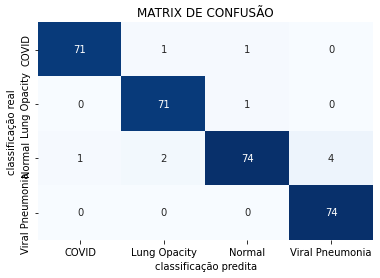

In [ ]:
# rotina de treino e validacao
l_epoca, l_loss, l_acc = routine_train_validate(model, l_labels, ds_train, ds_val, 15, criterion, optimizer)

In [ ]:
l_metrics = []
l_metrics.append(l_loss)
l_metrics.append(l_acc)
l_names = ['val_loss', 'val_acc']
save_data_json('./', name_model, 'Data', l_metrics, l_names)

{'resnet18': {'val_acc': [0.8717105263157895,
   0.930921052631579,
   0.9506578947368421,
   0.9539473684210527,
   0.9539473684210527,
   0.9605263157894737,
   0.9539473684210527,
   0.9638157894736842,
   0.9638157894736842,
   0.9638157894736842,
   0.9605263157894737,
   0.9605263157894737,
   0.9605263157894737,
   0.9605263157894737,
   0.9605263157894737],
  'val_loss': [0.38311372305217545,
   0.257090326447628,
   0.15202542784084616,
   0.13327732046232804,
   0.13708425088368945,
   0.13901122053319245,
   0.14036976329148992,
   0.12806542169020854,
   0.12423332193774465,
   0.1228602283609737,
   0.121844956351101,
   0.12109310206754967,
   0.12038958453922532,
   0.1198610393475974,
   0.11943852431738235]},
 'resnet50': {'val_acc': [0.7532894736842105,
   0.9342105263157895,
   0.9078947368421053,
   0.9572368421052632,
   0.944078947368421,
   0.9703947368421053,
   0.9638157894736842,
   0.9671052631578947,
   0.9703947368421053,
   0.9671052631578947,
   0.9671052

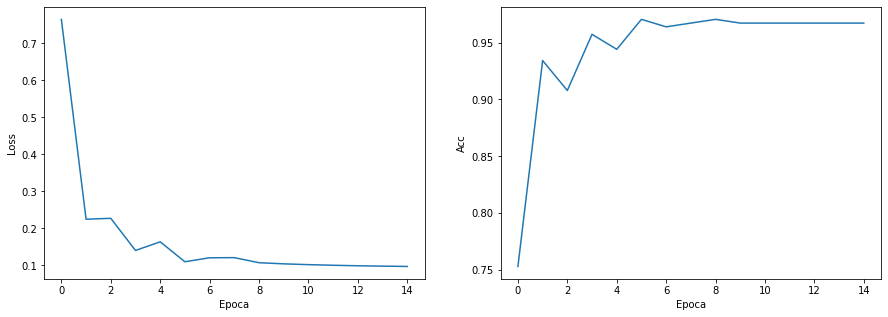

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_acc_loss(name_model, l_epoca, l_loss, l_acc)

Teste

  0%|          | 0/38 [00:00<?, ?it/s]

Accuracy Teste:    0.9473684210526315
Recall Score:      0.9505446308077887
Precission Score:  0.9503928290922408
F1:                0.9498871616095118
Loss Teste:        0.19711123497415284


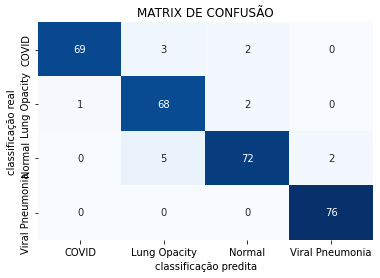

In [ ]:
view_test(model, ds_test, criterion, name_model, l_labels)

##ResNet152

In [ ]:
name_model = 'resnet152'
model = torchvision.models.resnet152(pretrained=False)
criterion = nn.CrossEntropyLoss().to(args['device'])
# optimizer = optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=0.9)

In [ ]:
model.fc = nn.Linear(2048,4)

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:2/15.. Train Loss: 1.146.. Val Loss: 0.973.. Val Acc:0.655.. Val Prec:0.686.. Val Rec:0.650.. Time: 3.65m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:3/15.. Train Loss: 0.812.. Val Loss: 0.705.. Val Acc:0.763.. Val Prec:0.776.. Val Rec:0.768.. Time: 3.65m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:4/15.. Train Loss: 0.642.. Val Loss: 0.676.. Val Acc:0.760.. Val Prec:0.768.. Val Rec:0.763.. Time: 3.65m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:5/15.. Train Loss: 0.518.. Val Loss: 0.677.. Val Acc:0.770.. Val Prec:0.782.. Val Rec:0.775.. Time: 3.64m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:6/15.. Train Loss: 0.427.. Val Loss: 0.714.. Val Acc:0.776.. Val Prec:0.792.. Val Rec:0.783.. Time: 3.65m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:7/15.. Train Loss: 0.353.. Val Loss: 0.909.. Val Acc:0.750.. Val Prec:0.770.. Val Rec:0.756.. Time: 3.65m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:8/15.. Train Loss: 0.344.. Val Loss: 0.781.. Val Acc:0.773.. Val Prec:0.786.. Val Rec:0.779.. Time: 3.64m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:9/15.. Train Loss: 0.284.. Val Loss: 0.808.. Val Acc:0.757.. Val Prec:0.775.. Val Rec:0.762.. Time: 3.65m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:10/15.. Train Loss: 0.257.. Val Loss: 0.876.. Val Acc:0.757.. Val Prec:0.770.. Val Rec:0.757.. Time: 3.65m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:11/15.. Train Loss: 0.203.. Val Loss: 0.853.. Val Acc:0.786.. Val Prec:0.803.. Val Rec:0.787.. Time: 3.65m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:12/15.. Train Loss: 0.165.. Val Loss: 0.824.. Val Acc:0.789.. Val Prec:0.817.. Val Rec:0.793.. Time: 3.65m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:13/15.. Train Loss: 0.140.. Val Loss: 0.742.. Val Acc:0.793.. Val Prec:0.806.. Val Rec:0.800.. Time: 3.64m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:14/15.. Train Loss: 0.082.. Val Loss: 0.721.. Val Acc:0.826.. Val Prec:0.839.. Val Rec:0.830.. Time: 3.64m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:15/15.. Train Loss: 0.072.. Val Loss: 0.769.. Val Acc:0.822.. Val Prec:0.829.. Val Rec:0.824.. Time: 3.64m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:16/15.. Train Loss: 0.062.. Val Loss: 0.679.. Val Acc:0.862.. Val Prec:0.869.. Val Rec:0.866.. Time: 3.64m

---------------------------------------Final Results---------------------------------------
Mean:  {'Acc': 0.7758771929824562, 'Prec': 0.7912455115354843, 'Rec': 0.7796229934387829, 'Loss': 0.7804820297881268}


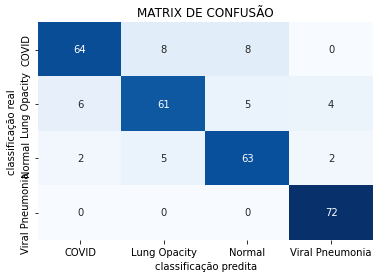

In [ ]:
# rotina de treino e validacao
l_epoca, l_loss, l_acc = routine_train_validate(model, l_labels, ds_train, ds_val, 15, criterion, optimizer)

In [ ]:
l_metrics = []
l_metrics.append(l_loss)
l_metrics.append(l_acc)
l_names = ['val_loss', 'val_acc']
save_data_json('./', name_model, 'Data', l_metrics, l_names)

{'resnet152': {'val_acc': [0.6546052631578947,
   0.7631578947368421,
   0.7598684210526315,
   0.7697368421052632,
   0.7763157894736842,
   0.75,
   0.7730263157894737,
   0.756578947368421,
   0.756578947368421,
   0.7861842105263158,
   0.7894736842105263,
   0.7927631578947368,
   0.8256578947368421,
   0.8223684210526315,
   0.8618421052631579],
  'val_loss': [0.9731934698004472,
   0.7047971910551974,
   0.6760851952590441,
   0.6772574111819267,
   0.7142839971929789,
   0.9088201449301682,
   0.7811820746252411,
   0.8082440578819889,
   0.8762860716026473,
   0.8527648241357192,
   0.8238551223307455,
   0.7423174326724716,
   0.7209535529668516,
   0.7686497200537767,
   0.6785401811326952]},
 'resnet18': {'val_acc': [0.8717105263157895,
   0.930921052631579,
   0.9506578947368421,
   0.9539473684210527,
   0.9539473684210527,
   0.9605263157894737,
   0.9539473684210527,
   0.9638157894736842,
   0.9638157894736842,
   0.9638157894736842,
   0.9605263157894737,
   0.9605263

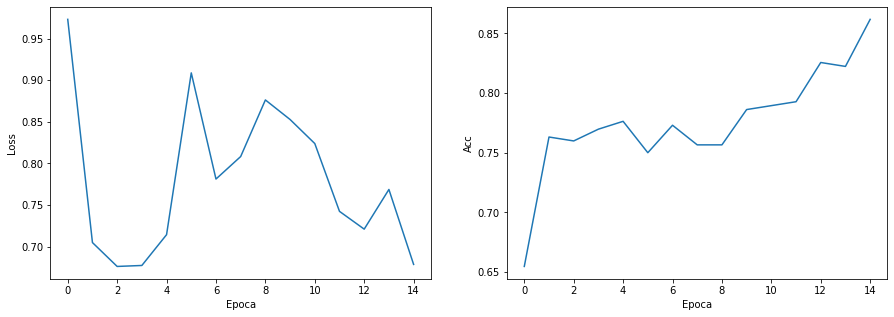

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_acc_loss(name_model, l_epoca, l_loss, l_acc)

Teste

  0%|          | 0/38 [00:00<?, ?it/s]

Accuracy Teste:    0.7763157894736842
Recall Score:      0.7777689415847311
Precission Score:  0.7830234736170891
F1:                0.7779878651814485
Loss Teste:        0.8817900039598738


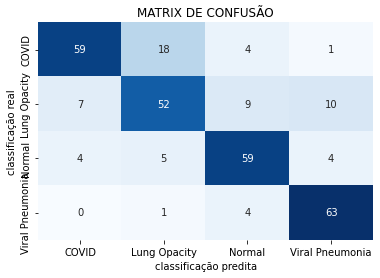

In [ ]:
view_test(model, ds_test, criterion, name_model, l_labels)

##ResNext50

In [ ]:
name_model = 'resnext50'
model = torchvision.models.resnext50_32x4d(pretrained=True)
criterion = nn.CrossEntropyLoss().to(args['device'])
# optimizer = optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=0.9)

In [ ]:
model.fc = nn.Linear(2048, 4)

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:2/15.. Train Loss: 0.643.. Val Loss: 0.405.. Val Acc:0.862.. Val Prec:0.890.. Val Rec:0.863.. Time: 1.70m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:3/15.. Train Loss: 0.341.. Val Loss: 0.162.. Val Acc:0.954.. Val Prec:0.953.. Val Rec:0.953.. Time: 1.68m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:4/15.. Train Loss: 0.185.. Val Loss: 0.191.. Val Acc:0.934.. Val Prec:0.940.. Val Rec:0.936.. Time: 1.68m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:5/15.. Train Loss: 0.104.. Val Loss: 0.172.. Val Acc:0.941.. Val Prec:0.943.. Val Rec:0.939.. Time: 1.68m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:6/15.. Train Loss: 0.051.. Val Loss: 0.137.. Val Acc:0.961.. Val Prec:0.960.. Val Rec:0.960.. Time: 1.68m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:7/15.. Train Loss: 0.033.. Val Loss: 0.157.. Val Acc:0.951.. Val Prec:0.951.. Val Rec:0.951.. Time: 1.68m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:8/15.. Train Loss: 0.014.. Val Loss: 0.129.. Val Acc:0.964.. Val Prec:0.964.. Val Rec:0.964.. Time: 1.68m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:9/15.. Train Loss: 0.008.. Val Loss: 0.105.. Val Acc:0.967.. Val Prec:0.967.. Val Rec:0.967.. Time: 1.68m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:10/15.. Train Loss: 0.004.. Val Loss: 0.105.. Val Acc:0.974.. Val Prec:0.974.. Val Rec:0.974.. Time: 1.68m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:11/15.. Train Loss: 0.003.. Val Loss: 0.105.. Val Acc:0.974.. Val Prec:0.974.. Val Rec:0.974.. Time: 1.68m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:12/15.. Train Loss: 0.003.. Val Loss: 0.106.. Val Acc:0.974.. Val Prec:0.974.. Val Rec:0.974.. Time: 1.68m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:13/15.. Train Loss: 0.002.. Val Loss: 0.106.. Val Acc:0.974.. Val Prec:0.974.. Val Rec:0.974.. Time: 1.68m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:14/15.. Train Loss: 0.002.. Val Loss: 0.106.. Val Acc:0.974.. Val Prec:0.974.. Val Rec:0.974.. Time: 1.68m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:15/15.. Train Loss: 0.002.. Val Loss: 0.107.. Val Acc:0.974.. Val Prec:0.974.. Val Rec:0.974.. Time: 1.68m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:16/15.. Train Loss: 0.002.. Val Loss: 0.107.. Val Acc:0.970.. Val Prec:0.971.. Val Rec:0.970.. Time: 1.68m

---------------------------------------Final Results---------------------------------------
Mean:  {'Acc': 0.9563596491228068, 'Prec': 0.9586931736244637, 'Rec': 0.9562272039245722, 'Loss': 0.14655183310254902}


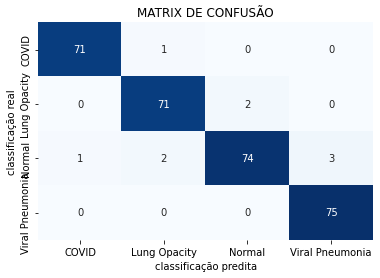

In [ ]:
# rotina de treino e validacao
l_epoca, l_loss, l_acc = routine_train_validate(model, l_labels, ds_train, ds_val, 15, criterion, optimizer)

In [ ]:
l_metrics = []
l_metrics.append(l_loss)
l_metrics.append(l_acc)
l_names = ['val_loss', 'val_acc']
save_data_json('./', name_model, 'Data', l_metrics, l_names)

{'resnet152': {'val_acc': [0.6546052631578947,
   0.7631578947368421,
   0.7598684210526315,
   0.7697368421052632,
   0.7763157894736842,
   0.75,
   0.7730263157894737,
   0.756578947368421,
   0.756578947368421,
   0.7861842105263158,
   0.7894736842105263,
   0.7927631578947368,
   0.8256578947368421,
   0.8223684210526315,
   0.8618421052631579],
  'val_loss': [0.9731934698004472,
   0.7047971910551974,
   0.6760851952590441,
   0.6772574111819267,
   0.7142839971929789,
   0.9088201449301682,
   0.7811820746252411,
   0.8082440578819889,
   0.8762860716026473,
   0.8527648241357192,
   0.8238551223307455,
   0.7423174326724716,
   0.7209535529668516,
   0.7686497200537767,
   0.6785401811326952]},
 'resnet18': {'val_acc': [0.8717105263157895,
   0.930921052631579,
   0.9506578947368421,
   0.9539473684210527,
   0.9539473684210527,
   0.9605263157894737,
   0.9539473684210527,
   0.9638157894736842,
   0.9638157894736842,
   0.9638157894736842,
   0.9605263157894737,
   0.9605263

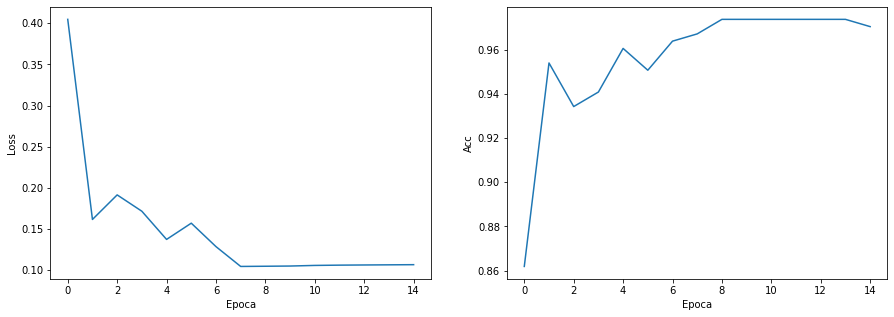

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_acc_loss(name_model, l_epoca, l_loss, l_acc)

Teste

  0%|          | 0/38 [00:00<?, ?it/s]

Accuracy Teste:    0.9703947368421053
Recall Score:      0.9704790823211876
Precission Score:  0.9699610701323029
F1:                0.969888568275665
Loss Teste:        0.13849545325808177


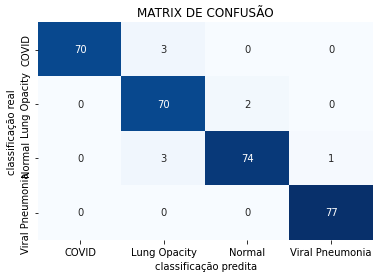

In [ ]:
view_test(model, ds_test, criterion, name_model, l_labels)

##ResNext101

In [ ]:
name_model = 'resnext101'
model = torchvision.models.resnext101_32x8d(pretrained=True)
criterion = nn.CrossEntropyLoss().to(args['device'])
# optimizer = optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=0.9)

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth


  0%|          | 0.00/340M [00:00<?, ?B/s]

In [ ]:
model.fc = nn.Linear(2048, 4)

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:2/15.. Train Loss: 0.614.. Val Loss: 0.437.. Val Acc:0.839.. Val Prec:0.857.. Val Rec:0.837.. Time: 3.20m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:3/15.. Train Loss: 0.388.. Val Loss: 0.230.. Val Acc:0.931.. Val Prec:0.935.. Val Rec:0.930.. Time: 2.51m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:4/15.. Train Loss: 0.208.. Val Loss: 0.225.. Val Acc:0.934.. Val Prec:0.937.. Val Rec:0.934.. Time: 2.57m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:5/15.. Train Loss: 0.107.. Val Loss: 0.157.. Val Acc:0.924.. Val Prec:0.925.. Val Rec:0.923.. Time: 2.60m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:6/15.. Train Loss: 0.057.. Val Loss: 0.141.. Val Acc:0.947.. Val Prec:0.947.. Val Rec:0.947.. Time: 2.57m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:7/15.. Train Loss: 0.029.. Val Loss: 0.145.. Val Acc:0.954.. Val Prec:0.954.. Val Rec:0.954.. Time: 2.58m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:8/15.. Train Loss: 0.013.. Val Loss: 0.147.. Val Acc:0.957.. Val Prec:0.957.. Val Rec:0.957.. Time: 2.58m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:9/15.. Train Loss: 0.007.. Val Loss: 0.109.. Val Acc:0.964.. Val Prec:0.964.. Val Rec:0.964.. Time: 2.57m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:10/15.. Train Loss: 0.004.. Val Loss: 0.109.. Val Acc:0.957.. Val Prec:0.957.. Val Rec:0.957.. Time: 2.58m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:11/15.. Train Loss: 0.003.. Val Loss: 0.108.. Val Acc:0.961.. Val Prec:0.961.. Val Rec:0.960.. Time: 2.57m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:12/15.. Train Loss: 0.002.. Val Loss: 0.108.. Val Acc:0.964.. Val Prec:0.964.. Val Rec:0.963.. Time: 2.57m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:13/15.. Train Loss: 0.002.. Val Loss: 0.108.. Val Acc:0.964.. Val Prec:0.964.. Val Rec:0.963.. Time: 2.57m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:14/15.. Train Loss: 0.002.. Val Loss: 0.108.. Val Acc:0.967.. Val Prec:0.967.. Val Rec:0.967.. Time: 2.57m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:15/15.. Train Loss: 0.002.. Val Loss: 0.108.. Val Acc:0.967.. Val Prec:0.967.. Val Rec:0.967.. Time: 2.57m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:16/15.. Train Loss: 0.001.. Val Loss: 0.109.. Val Acc:0.967.. Val Prec:0.967.. Val Rec:0.967.. Time: 2.57m

---------------------------------------Final Results---------------------------------------
Mean:  {'Acc': 0.9464912280701756, 'Prec': 0.9480471953832412, 'Rec': 0.9459117265038317, 'Loss': 0.15663001528406756}


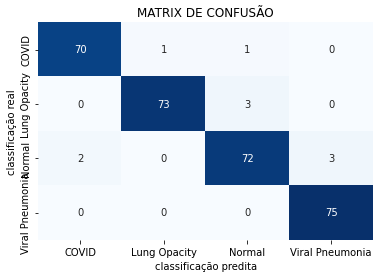

In [ ]:
# rotina de treino e validacao
l_epoca, l_loss, l_acc = routine_train_validate(model, l_labels, ds_train, ds_val, 15, criterion, optimizer)

In [ ]:
l_metrics = []
l_metrics.append(l_loss)
l_metrics.append(l_acc)
l_names = ['val_loss', 'val_acc']
save_data_json('./', name_model, 'Data', l_metrics, l_names)

{'efficientnet_b7': {'val_acc': [0.9046052631578947,
   0.9407894736842105,
   0.9638157894736842,
   0.9473684210526315,
   0.9638157894736842,
   0.9703947368421053,
   0.9703947368421053,
   0.9703947368421053,
   0.9703947368421053,
   0.9703947368421053,
   0.9769736842105263,
   0.9703947368421053,
   0.9703947368421053,
   0.9769736842105263,
   0.9671052631578947],
  'val_loss': [0.37604530390940216,
   0.1789529474550172,
   0.1404145971847404,
   0.17437689181564278,
   0.10534835384398895,
   0.10408562190193486,
   0.10892875222979408,
   0.10717140640573282,
   0.10788072818755418,
   0.09093681636793342,
   0.08901384861919244,
   0.0921632835831444,
   0.09832766733751142,
   0.09246951423272931,
   0.09617821712469633]},
 'resnet152': {'val_acc': [0.6546052631578947,
   0.7631578947368421,
   0.7598684210526315,
   0.7697368421052632,
   0.7763157894736842,
   0.75,
   0.7730263157894737,
   0.756578947368421,
   0.756578947368421,
   0.7861842105263158,
   0.7894736842

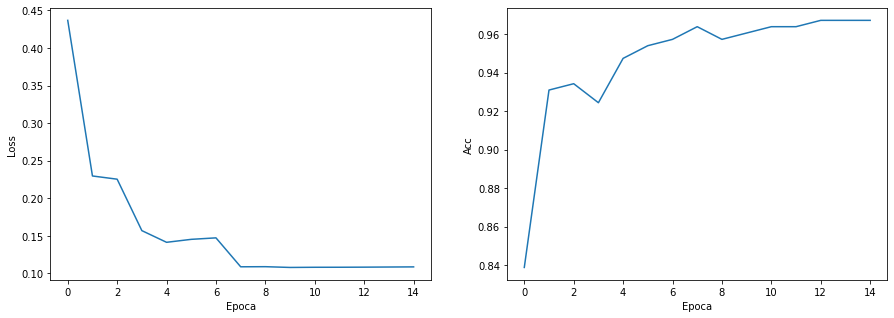

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_acc_loss(name_model, l_epoca, l_loss, l_acc)

Teste

  0%|          | 0/38 [00:00<?, ?it/s]

Accuracy Teste:    0.9703947368421053
Recall Score:      0.9718343182381594
Precission Score:  0.9733178053830228
F1:                0.9724621346675635
Loss Teste:        0.1358466155097152


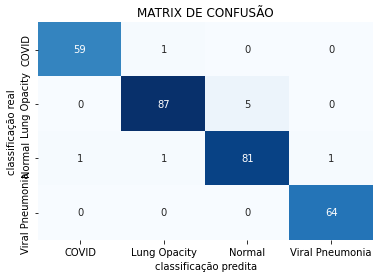

In [ ]:
view_test(model, ds_test, criterion, name_model, l_labels)

##EfficientNet_b1

In [ ]:
name_model = 'efficientnet_b1'
model = torchvision.models.efficientnet_b1(pretrained=True)
criterion = nn.CrossEntropyLoss().to(args['device'])
optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=0.9)

In [ ]:
model.classifier[1] = nn.Linear(1280,4)

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:2/15.. Train Loss: 0.743.. Val Loss: 0.262.. Val Acc:0.911.. Val Prec:0.919.. Val Rec:0.913.. Time: 4.94m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:3/15.. Train Loss: 0.341.. Val Loss: 0.209.. Val Acc:0.924.. Val Prec:0.930.. Val Rec:0.926.. Time: 0.43m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:4/15.. Train Loss: 0.168.. Val Loss: 0.163.. Val Acc:0.941.. Val Prec:0.946.. Val Rec:0.942.. Time: 0.43m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:5/15.. Train Loss: 0.102.. Val Loss: 0.158.. Val Acc:0.947.. Val Prec:0.952.. Val Rec:0.946.. Time: 0.43m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:6/15.. Train Loss: 0.078.. Val Loss: 0.138.. Val Acc:0.947.. Val Prec:0.950.. Val Rec:0.946.. Time: 0.53m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:7/15.. Train Loss: 0.064.. Val Loss: 0.146.. Val Acc:0.944.. Val Prec:0.953.. Val Rec:0.946.. Time: 0.62m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:8/15.. Train Loss: 0.045.. Val Loss: 0.144.. Val Acc:0.947.. Val Prec:0.952.. Val Rec:0.946.. Time: 0.58m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:9/15.. Train Loss: 0.036.. Val Loss: 0.158.. Val Acc:0.951.. Val Prec:0.954.. Val Rec:0.949.. Time: 0.56m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:10/15.. Train Loss: 0.025.. Val Loss: 0.134.. Val Acc:0.957.. Val Prec:0.961.. Val Rec:0.956.. Time: 0.52m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:11/15.. Train Loss: 0.026.. Val Loss: 0.147.. Val Acc:0.951.. Val Prec:0.954.. Val Rec:0.949.. Time: 0.43m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:12/15.. Train Loss: 0.017.. Val Loss: 0.137.. Val Acc:0.951.. Val Prec:0.954.. Val Rec:0.950.. Time: 0.44m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:13/15.. Train Loss: 0.021.. Val Loss: 0.152.. Val Acc:0.944.. Val Prec:0.948.. Val Rec:0.943.. Time: 0.43m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:14/15.. Train Loss: 0.013.. Val Loss: 0.128.. Val Acc:0.961.. Val Prec:0.962.. Val Rec:0.960.. Time: 0.43m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:15/15.. Train Loss: 0.010.. Val Loss: 0.141.. Val Acc:0.951.. Val Prec:0.954.. Val Rec:0.949.. Time: 0.44m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:16/15.. Train Loss: 0.009.. Val Loss: 0.137.. Val Acc:0.961.. Val Prec:0.962.. Val Rec:0.960.. Time: 0.43m

---------------------------------------Final Results---------------------------------------
Mean:  {'Acc': 0.9458333333333335, 'Prec': 0.9500178988195389, 'Rec': 0.945442887219203, 'Loss': 0.15702054974849725}


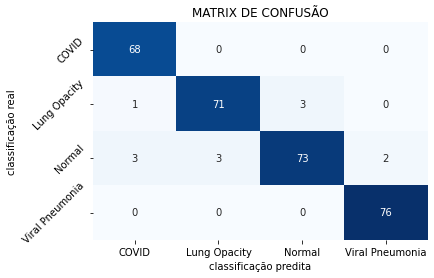

In [ ]:
# rotina de treino e validacao
l_epoca, l_loss, l_acc = routine_train_validate(model, l_labels, ds_train, ds_val, 15, criterion, optimizer)

In [ ]:
torch.save(model, name_model+'.pth')

In [ ]:
l_metrics = []
l_metrics.append(l_loss)
l_metrics.append(l_acc)
l_names = ['val_loss', 'val_acc']
save_data_json('./', name_model, 'Data', l_metrics, l_names)

{'efficientnet_b1': {'val_acc': [0.9111842105263158,
   0.9243421052631579,
   0.9407894736842105,
   0.9473684210526315,
   0.9473684210526315,
   0.944078947368421,
   0.9473684210526315,
   0.9506578947368421,
   0.9572368421052632,
   0.9506578947368421,
   0.9506578947368421,
   0.944078947368421,
   0.9605263157894737,
   0.9506578947368421,
   0.9605263157894737],
  'val_loss': [0.26233815842945324,
   0.20891535885043835,
   0.16284183638268396,
   0.15849489565497557,
   0.13812631514462592,
   0.1463858697526647,
   0.14424702097772082,
   0.1581615421026455,
   0.13363359414353526,
   0.14748785614440413,
   0.13701673601080025,
   0.1516407653413664,
   0.12786340490167372,
   0.14066363125120437,
   0.137491261139267]},
 'efficientnet_b7': {'val_acc': [0.9013157894736842,
   0.9572368421052632,
   0.9572368421052632,
   0.9671052631578947,
   0.9506578947368421,
   0.9638157894736842,
   0.9736842105263158,
   0.9703947368421053,
   0.9736842105263158,
   0.980263157894736

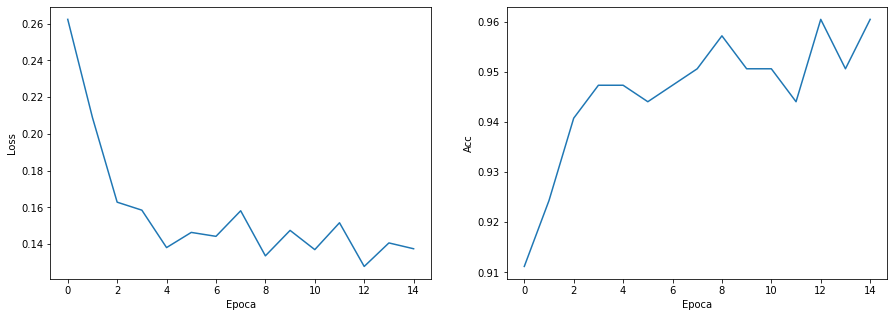

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_acc_loss(name_model, l_epoca, l_loss, l_acc)

Teste

  0%|          | 0/38 [00:00<?, ?it/s]

Accuracy Teste:    0.9605263157894737
Recall Score:      0.9602154424522846
Precission Score:  0.9620191682910981
F1:                0.9607779775603074
Loss Teste:        0.14398646474383944


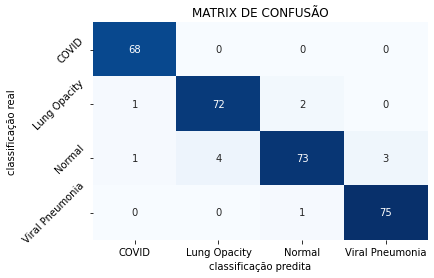

In [ ]:
view_test(model, ds_test, criterion, name_model, l_labels)

##EfficientNet_b2

In [ ]:
name_model = 'efficientnet_b2'
model = torchvision.models.efficientnet_b2(pretrained=True)
criterion = nn.CrossEntropyLoss().to(args['device'])
optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=0.9)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth


  0%|          | 0.00/35.2M [00:00<?, ?B/s]

In [ ]:
model.classifier[1] = nn.Linear(1408,4)

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:2/15.. Train Loss: 0.699.. Val Loss: 0.319.. Val Acc:0.888.. Val Prec:0.896.. Val Rec:0.887.. Time: 0.46m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:3/15.. Train Loss: 0.318.. Val Loss: 0.214.. Val Acc:0.914.. Val Prec:0.927.. Val Rec:0.916.. Time: 0.45m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:4/15.. Train Loss: 0.184.. Val Loss: 0.159.. Val Acc:0.934.. Val Prec:0.938.. Val Rec:0.932.. Time: 0.45m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:5/15.. Train Loss: 0.103.. Val Loss: 0.130.. Val Acc:0.961.. Val Prec:0.960.. Val Rec:0.960.. Time: 0.46m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:6/15.. Train Loss: 0.062.. Val Loss: 0.142.. Val Acc:0.941.. Val Prec:0.943.. Val Rec:0.940.. Time: 0.45m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:7/15.. Train Loss: 0.047.. Val Loss: 0.128.. Val Acc:0.961.. Val Prec:0.965.. Val Rec:0.963.. Time: 0.45m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:8/15.. Train Loss: 0.045.. Val Loss: 0.119.. Val Acc:0.954.. Val Prec:0.957.. Val Rec:0.957.. Time: 0.45m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:9/15.. Train Loss: 0.041.. Val Loss: 0.138.. Val Acc:0.951.. Val Prec:0.952.. Val Rec:0.950.. Time: 0.46m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:10/15.. Train Loss: 0.028.. Val Loss: 0.166.. Val Acc:0.947.. Val Prec:0.951.. Val Rec:0.947.. Time: 0.45m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:11/15.. Train Loss: 0.017.. Val Loss: 0.109.. Val Acc:0.954.. Val Prec:0.956.. Val Rec:0.953.. Time: 0.45m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:12/15.. Train Loss: 0.016.. Val Loss: 0.213.. Val Acc:0.938.. Val Prec:0.945.. Val Rec:0.937.. Time: 0.45m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:13/15.. Train Loss: 0.013.. Val Loss: 0.113.. Val Acc:0.961.. Val Prec:0.962.. Val Rec:0.960.. Time: 0.46m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:14/15.. Train Loss: 0.023.. Val Loss: 0.164.. Val Acc:0.957.. Val Prec:0.961.. Val Rec:0.956.. Time: 0.45m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:15/15.. Train Loss: 0.012.. Val Loss: 0.109.. Val Acc:0.957.. Val Prec:0.959.. Val Rec:0.957.. Time: 0.45m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:16/15.. Train Loss: 0.012.. Val Loss: 0.093.. Val Acc:0.970.. Val Prec:0.970.. Val Rec:0.970.. Time: 0.45m

---------------------------------------Final Results---------------------------------------
Mean:  {'Acc': 0.9458333333333335, 'Prec': 0.9494403818111098, 'Rec': 0.9457585875349033, 'Loss': 0.15429973554523793}


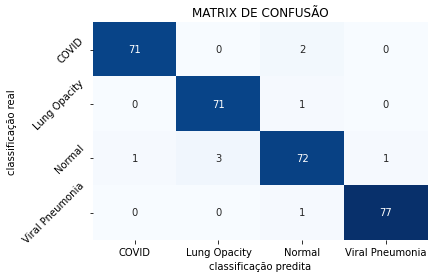

In [ ]:
# rotina de treino e validacao
l_epoca, l_loss, l_acc = routine_train_validate(model, l_labels, ds_train, ds_val, 15, criterion, optimizer)

In [ ]:
torch.save(model, name_model+'.pth')

In [ ]:
l_metrics = []
l_metrics.append(l_loss)
l_metrics.append(l_acc)
l_names = ['val_loss', 'val_acc']
save_data_json('./', name_model, 'Data', l_metrics, l_names)

{'efficientnet_b1': {'val_acc': [0.9111842105263158,
   0.9243421052631579,
   0.9407894736842105,
   0.9473684210526315,
   0.9473684210526315,
   0.944078947368421,
   0.9473684210526315,
   0.9506578947368421,
   0.9572368421052632,
   0.9506578947368421,
   0.9506578947368421,
   0.944078947368421,
   0.9605263157894737,
   0.9506578947368421,
   0.9605263157894737],
  'val_loss': [0.26233815842945324,
   0.20891535885043835,
   0.16284183638268396,
   0.15849489565497557,
   0.13812631514462592,
   0.1463858697526647,
   0.14424702097772082,
   0.1581615421026455,
   0.13363359414353526,
   0.14748785614440413,
   0.13701673601080025,
   0.1516407653413664,
   0.12786340490167372,
   0.14066363125120437,
   0.137491261139267]},
 'efficientnet_b2': {'val_acc': [0.8881578947368421,
   0.9144736842105263,
   0.9342105263157895,
   0.9605263157894737,
   0.9407894736842105,
   0.9605263157894737,
   0.9539473684210527,
   0.9506578947368421,
   0.9473684210526315,
   0.953947368421052

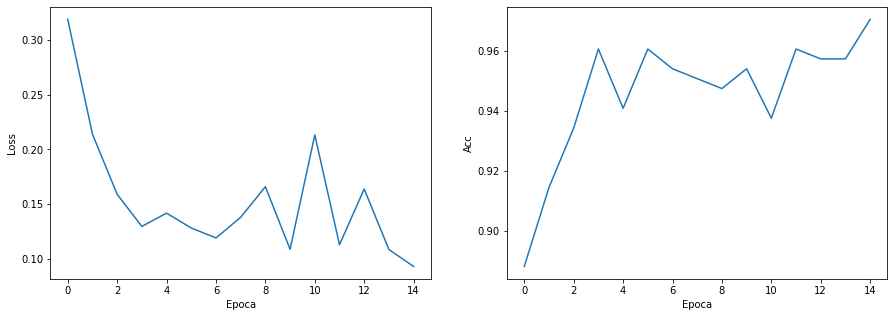

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_acc_loss(name_model, l_epoca, l_loss, l_acc)

Teste

  0%|          | 0/38 [00:00<?, ?it/s]

Accuracy Teste:    0.9539473684210527
Recall Score:      0.9572079236552922
Precission Score:  0.9574819254185692
F1:                0.9568176259352731
Loss Teste:        0.16100230293293288


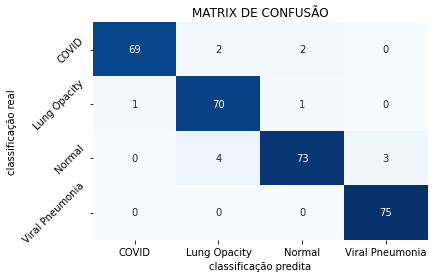

In [ ]:
view_test(model, ds_test, criterion, name_model, l_labels)

##EfficientNet_b3

In [ ]:
name_model = 'efficientnet_b3'
model = torchvision.models.efficientnet_b3(pretrained=True)
criterion = nn.CrossEntropyLoss().to(args['device'])
optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=0.9)

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-cf984f9c.pth


  0%|          | 0.00/47.2M [00:00<?, ?B/s]

In [ ]:
model.classifier[1] = nn.Linear(1536,4)

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:2/15.. Train Loss: 0.927.. Val Loss: 0.372.. Val Acc:0.895.. Val Prec:0.902.. Val Rec:0.895.. Time: 0.56m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:3/15.. Train Loss: 0.413.. Val Loss: 0.266.. Val Acc:0.898.. Val Prec:0.910.. Val Rec:0.900.. Time: 0.55m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:4/15.. Train Loss: 0.228.. Val Loss: 0.234.. Val Acc:0.918.. Val Prec:0.925.. Val Rec:0.916.. Time: 0.54m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:5/15.. Train Loss: 0.152.. Val Loss: 0.212.. Val Acc:0.934.. Val Prec:0.941.. Val Rec:0.937.. Time: 0.54m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:6/15.. Train Loss: 0.104.. Val Loss: 0.198.. Val Acc:0.934.. Val Prec:0.940.. Val Rec:0.937.. Time: 0.54m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:7/15.. Train Loss: 0.073.. Val Loss: 0.208.. Val Acc:0.928.. Val Prec:0.941.. Val Rec:0.930.. Time: 0.54m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:8/15.. Train Loss: 0.046.. Val Loss: 0.184.. Val Acc:0.938.. Val Prec:0.944.. Val Rec:0.940.. Time: 0.54m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:9/15.. Train Loss: 0.039.. Val Loss: 0.215.. Val Acc:0.931.. Val Prec:0.943.. Val Rec:0.933.. Time: 0.54m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:10/15.. Train Loss: 0.031.. Val Loss: 0.224.. Val Acc:0.934.. Val Prec:0.944.. Val Rec:0.937.. Time: 0.54m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:11/15.. Train Loss: 0.032.. Val Loss: 0.249.. Val Acc:0.931.. Val Prec:0.940.. Val Rec:0.933.. Time: 0.54m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:12/15.. Train Loss: 0.027.. Val Loss: 0.175.. Val Acc:0.944.. Val Prec:0.951.. Val Rec:0.946.. Time: 0.54m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:13/15.. Train Loss: 0.023.. Val Loss: 0.169.. Val Acc:0.954.. Val Prec:0.961.. Val Rec:0.957.. Time: 0.55m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:14/15.. Train Loss: 0.017.. Val Loss: 0.263.. Val Acc:0.938.. Val Prec:0.949.. Val Rec:0.940.. Time: 0.54m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:15/15.. Train Loss: 0.019.. Val Loss: 0.283.. Val Acc:0.934.. Val Prec:0.945.. Val Rec:0.936.. Time: 0.54m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:16/15.. Train Loss: 0.023.. Val Loss: 0.207.. Val Acc:0.944.. Val Prec:0.952.. Val Rec:0.947.. Time: 0.54m

---------------------------------------Final Results---------------------------------------
Mean:  {'Acc': 0.9302631578947369, 'Prec': 0.9391746404569452, 'Rec': 0.9322663756874284, 'Loss': 0.2306024934257597}


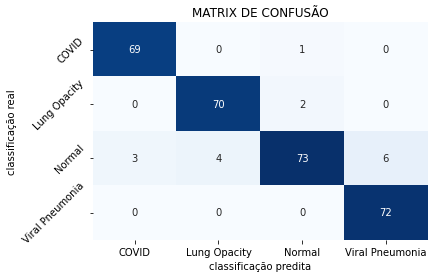

In [ ]:
# rotina de treino e validacao
l_epoca, l_loss, l_acc = routine_train_validate(model, l_labels, ds_train, ds_val, 15, criterion, optimizer)

In [ ]:
torch.save(model, name_model+'.pth')

In [ ]:
l_metrics = []
l_metrics.append(l_loss)
l_metrics.append(l_acc)
l_names = ['val_loss', 'val_acc']
save_data_json('./', name_model, 'Data', l_metrics, l_names)

{'efficientnet_b1': {'val_acc': [0.9111842105263158,
   0.9243421052631579,
   0.9407894736842105,
   0.9473684210526315,
   0.9473684210526315,
   0.944078947368421,
   0.9473684210526315,
   0.9506578947368421,
   0.9572368421052632,
   0.9506578947368421,
   0.9506578947368421,
   0.944078947368421,
   0.9605263157894737,
   0.9506578947368421,
   0.9605263157894737],
  'val_loss': [0.26233815842945324,
   0.20891535885043835,
   0.16284183638268396,
   0.15849489565497557,
   0.13812631514462592,
   0.1463858697526647,
   0.14424702097772082,
   0.1581615421026455,
   0.13363359414353526,
   0.14748785614440413,
   0.13701673601080025,
   0.1516407653413664,
   0.12786340490167372,
   0.14066363125120437,
   0.137491261139267]},
 'efficientnet_b2': {'val_acc': [0.8881578947368421,
   0.9144736842105263,
   0.9342105263157895,
   0.9605263157894737,
   0.9407894736842105,
   0.9605263157894737,
   0.9539473684210527,
   0.9506578947368421,
   0.9473684210526315,
   0.953947368421052

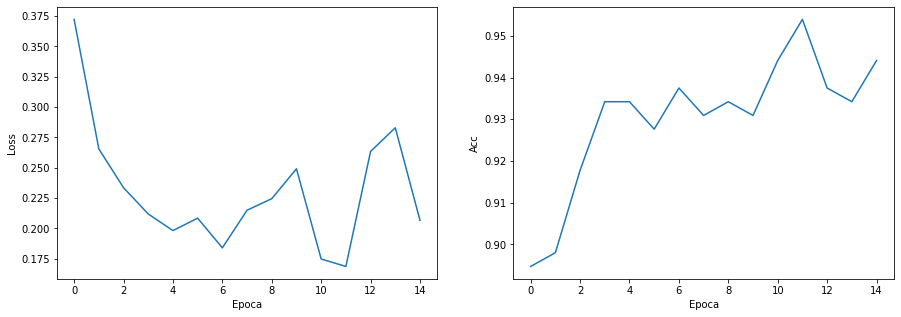

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_acc_loss(name_model, l_epoca, l_loss, l_acc)

Teste

  0%|          | 0/38 [00:00<?, ?it/s]

Accuracy Teste:    0.9473684210526315
Recall Score:      0.9465779834200887
Precission Score:  0.9480799592564298
F1:                0.9470238485583755
Loss Teste:        0.21442970147625984


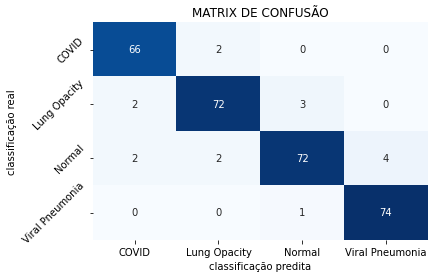

In [ ]:
view_test(model, ds_test, criterion, name_model, l_labels)

##EfficientNet_b4

In [ ]:
name_model = 'efficientnet_b4'
model = torchvision.models.efficientnet_b4(pretrained=True)
criterion = nn.CrossEntropyLoss().to(args['device'])
optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=0.9)

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-7eb33cd5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-7eb33cd5.pth


  0%|          | 0.00/74.5M [00:00<?, ?B/s]

In [ ]:
model.classifier[1] = nn.Linear(1792,4)

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:2/15.. Train Loss: 1.366.. Val Loss: 1.339.. Val Acc:0.461.. Val Prec:0.515.. Val Rec:0.466.. Time: 0.72m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:3/15.. Train Loss: 1.314.. Val Loss: 1.245.. Val Acc:0.523.. Val Prec:0.669.. Val Rec:0.530.. Time: 0.72m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:4/15.. Train Loss: 1.158.. Val Loss: 0.900.. Val Acc:0.760.. Val Prec:0.823.. Val Rec:0.767.. Time: 0.73m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:5/15.. Train Loss: 0.878.. Val Loss: 0.494.. Val Acc:0.852.. Val Prec:0.859.. Val Rec:0.855.. Time: 0.71m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:6/15.. Train Loss: 0.611.. Val Loss: 0.363.. Val Acc:0.888.. Val Prec:0.896.. Val Rec:0.889.. Time: 0.71m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:7/15.. Train Loss: 0.466.. Val Loss: 0.289.. Val Acc:0.911.. Val Prec:0.916.. Val Rec:0.909.. Time: 0.72m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:8/15.. Train Loss: 0.369.. Val Loss: 0.219.. Val Acc:0.934.. Val Prec:0.937.. Val Rec:0.933.. Time: 0.72m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:9/15.. Train Loss: 0.284.. Val Loss: 0.209.. Val Acc:0.931.. Val Prec:0.934.. Val Rec:0.929.. Time: 0.71m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:10/15.. Train Loss: 0.232.. Val Loss: 0.200.. Val Acc:0.934.. Val Prec:0.939.. Val Rec:0.933.. Time: 0.71m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:11/15.. Train Loss: 0.172.. Val Loss: 0.169.. Val Acc:0.941.. Val Prec:0.945.. Val Rec:0.940.. Time: 0.72m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:12/15.. Train Loss: 0.143.. Val Loss: 0.217.. Val Acc:0.931.. Val Prec:0.938.. Val Rec:0.930.. Time: 0.72m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:13/15.. Train Loss: 0.114.. Val Loss: 0.201.. Val Acc:0.934.. Val Prec:0.938.. Val Rec:0.933.. Time: 0.72m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:14/15.. Train Loss: 0.089.. Val Loss: 0.177.. Val Acc:0.947.. Val Prec:0.951.. Val Rec:0.947.. Time: 0.72m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:15/15.. Train Loss: 0.080.. Val Loss: 0.160.. Val Acc:0.941.. Val Prec:0.944.. Val Rec:0.939.. Time: 0.71m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:16/15.. Train Loss: 0.067.. Val Loss: 0.185.. Val Acc:0.941.. Val Prec:0.944.. Val Rec:0.940.. Time: 0.71m

---------------------------------------Final Results---------------------------------------
Mean:  {'Acc': 0.8552631578947368, 'Prec': 0.8763425759707208, 'Rec': 0.8559841724315408, 'Loss': 0.42442319258517003}


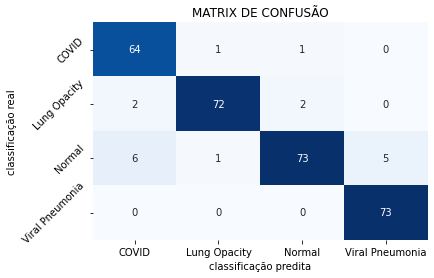

In [ ]:
# rotina de treino e validacao
l_epoca, l_loss, l_acc = routine_train_validate(model, l_labels, ds_train, ds_val, 15, criterion, optimizer)

In [ ]:
torch.save(model, name_model+'.pth')

In [ ]:
l_metrics = []
l_metrics.append(l_loss)
l_metrics.append(l_acc)
l_names = ['val_loss', 'val_acc']
save_data_json('./', name_model, 'Data', l_metrics, l_names)

{'efficientnet_b1': {'val_acc': [0.9111842105263158,
   0.9243421052631579,
   0.9407894736842105,
   0.9473684210526315,
   0.9473684210526315,
   0.944078947368421,
   0.9473684210526315,
   0.9506578947368421,
   0.9572368421052632,
   0.9506578947368421,
   0.9506578947368421,
   0.944078947368421,
   0.9605263157894737,
   0.9506578947368421,
   0.9605263157894737],
  'val_loss': [0.26233815842945324,
   0.20891535885043835,
   0.16284183638268396,
   0.15849489565497557,
   0.13812631514462592,
   0.1463858697526647,
   0.14424702097772082,
   0.1581615421026455,
   0.13363359414353526,
   0.14748785614440413,
   0.13701673601080025,
   0.1516407653413664,
   0.12786340490167372,
   0.14066363125120437,
   0.137491261139267]},
 'efficientnet_b2': {'val_acc': [0.8881578947368421,
   0.9144736842105263,
   0.9342105263157895,
   0.9605263157894737,
   0.9407894736842105,
   0.9605263157894737,
   0.9539473684210527,
   0.9506578947368421,
   0.9473684210526315,
   0.953947368421052

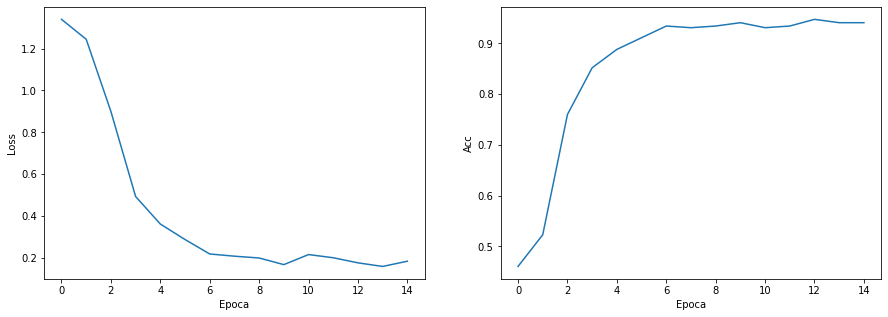

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_acc_loss(name_model, l_epoca, l_loss, l_acc)

Teste

  0%|          | 0/38 [00:00<?, ?it/s]

Accuracy Teste:    0.9078947368421053
Recall Score:      0.9087863890495469
Precission Score:  0.9138990087265949
F1:                0.9098356519709416
Loss Teste:        0.22373312925552263


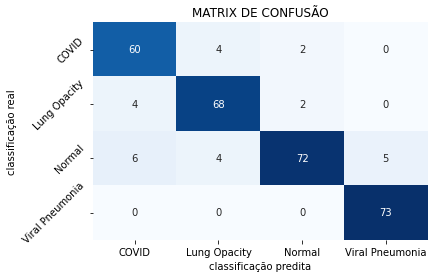

In [ ]:
view_test(model, ds_test, criterion, name_model, l_labels)

##EfficientNet_b5

In [25]:
name_model = 'efficientnet_b5'
model = torchvision.models.efficientnet_b5(pretrained=True)
criterion = nn.CrossEntropyLoss().to(args['device'])
optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=0.9)

Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b5_lukemelas-b6417697.pth


  0%|          | 0.00/117M [00:00<?, ?B/s]

In [26]:
model.classifier[1] = nn.Linear(2048,4)

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:2/15.. Train Loss: 0.851.. Val Loss: 0.317.. Val Acc:0.921.. Val Prec:0.929.. Val Rec:0.919.. Time: 2.65m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:3/15.. Train Loss: 0.342.. Val Loss: 0.170.. Val Acc:0.944.. Val Prec:0.949.. Val Rec:0.943.. Time: 0.95m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:4/15.. Train Loss: 0.175.. Val Loss: 0.155.. Val Acc:0.947.. Val Prec:0.948.. Val Rec:0.946.. Time: 0.97m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:5/15.. Train Loss: 0.107.. Val Loss: 0.171.. Val Acc:0.934.. Val Prec:0.941.. Val Rec:0.933.. Time: 0.99m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:6/15.. Train Loss: 0.073.. Val Loss: 0.123.. Val Acc:0.961.. Val Prec:0.961.. Val Rec:0.960.. Time: 0.99m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:7/15.. Train Loss: 0.052.. Val Loss: 0.144.. Val Acc:0.954.. Val Prec:0.957.. Val Rec:0.954.. Time: 0.99m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:8/15.. Train Loss: 0.039.. Val Loss: 0.117.. Val Acc:0.967.. Val Prec:0.969.. Val Rec:0.967.. Time: 1.00m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:9/15.. Train Loss: 0.031.. Val Loss: 0.119.. Val Acc:0.961.. Val Prec:0.962.. Val Rec:0.960.. Time: 1.00m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:10/15.. Train Loss: 0.024.. Val Loss: 0.120.. Val Acc:0.964.. Val Prec:0.964.. Val Rec:0.964.. Time: 0.99m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:11/15.. Train Loss: 0.017.. Val Loss: 0.126.. Val Acc:0.964.. Val Prec:0.965.. Val Rec:0.964.. Time: 1.00m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:12/15.. Train Loss: 0.014.. Val Loss: 0.140.. Val Acc:0.951.. Val Prec:0.954.. Val Rec:0.950.. Time: 0.99m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:13/15.. Train Loss: 0.014.. Val Loss: 0.145.. Val Acc:0.954.. Val Prec:0.955.. Val Rec:0.953.. Time: 1.00m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:14/15.. Train Loss: 0.011.. Val Loss: 0.125.. Val Acc:0.954.. Val Prec:0.956.. Val Rec:0.953.. Time: 1.00m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:15/15.. Train Loss: 0.010.. Val Loss: 0.116.. Val Acc:0.961.. Val Prec:0.962.. Val Rec:0.960.. Time: 0.99m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:16/15.. Train Loss: 0.009.. Val Loss: 0.113.. Val Acc:0.964.. Val Prec:0.964.. Val Rec:0.963.. Time: 0.99m

---------------------------------------Final Results---------------------------------------
Mean:  {'Acc': 0.9532894736842107, 'Prec': 0.9555693981747234, 'Rec': 0.952492750848014, 'Loss': 0.14665489222215114}


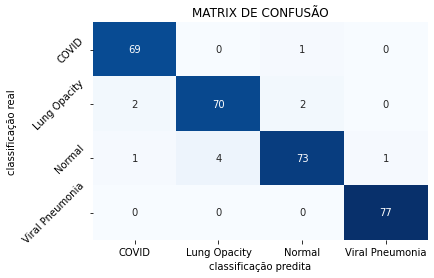

In [27]:
# rotina de treino e validacao
l_epoca, l_loss, l_acc = routine_train_validate(model, l_labels, ds_train, ds_val, 15, criterion, optimizer)

In [28]:
torch.save(model, name_model+'.pth')

In [29]:
l_metrics = []
l_metrics.append(l_loss)
l_metrics.append(l_acc)
l_names = ['val_loss', 'val_acc']
save_data_json('./', name_model, 'Data', l_metrics, l_names)

{'efficientnet_b1': {'val_acc': [0.9111842105263158,
   0.9243421052631579,
   0.9407894736842105,
   0.9473684210526315,
   0.9473684210526315,
   0.944078947368421,
   0.9473684210526315,
   0.9506578947368421,
   0.9572368421052632,
   0.9506578947368421,
   0.9506578947368421,
   0.944078947368421,
   0.9605263157894737,
   0.9506578947368421,
   0.9605263157894737],
  'val_loss': [0.26233815842945324,
   0.20891535885043835,
   0.16284183638268396,
   0.15849489565497557,
   0.13812631514462592,
   0.1463858697526647,
   0.14424702097772082,
   0.1581615421026455,
   0.13363359414353526,
   0.14748785614440413,
   0.13701673601080025,
   0.1516407653413664,
   0.12786340490167372,
   0.14066363125120437,
   0.137491261139267]},
 'efficientnet_b2': {'val_acc': [0.8881578947368421,
   0.9144736842105263,
   0.9342105263157895,
   0.9605263157894737,
   0.9407894736842105,
   0.9605263157894737,
   0.9539473684210527,
   0.9506578947368421,
   0.9473684210526315,
   0.953947368421052

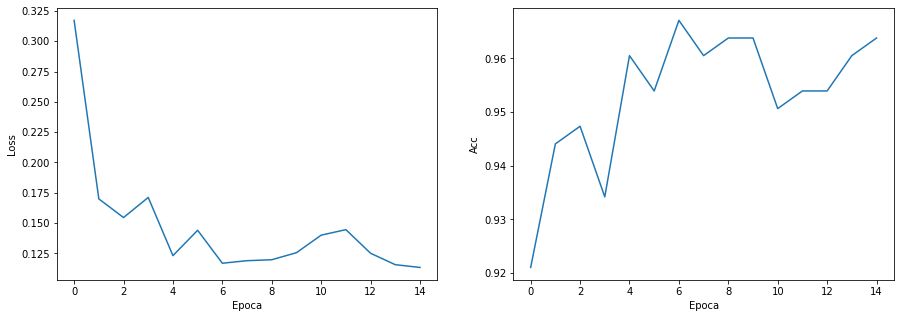

<Figure size 432x288 with 0 Axes>

In [30]:
plot_acc_loss(name_model, l_epoca, l_loss, l_acc)

Teste

  0%|          | 0/38 [00:00<?, ?it/s]

Accuracy Teste:    0.9572368421052632
Recall Score:      0.9599334875650666
Precission Score:  0.9624518613607188
F1:                0.960642907113973
Loss Teste:        0.15931315662792736


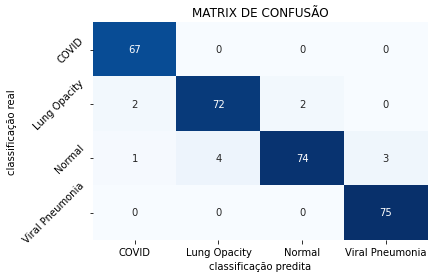

In [31]:
view_test(model, ds_test, criterion, name_model, l_labels)

##EfficientNet_b6

In [32]:
name_model = 'efficientnet_b6'
model = torchvision.models.efficientnet_b6(pretrained=True)
criterion = nn.CrossEntropyLoss().to(args['device'])
optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=0.9)

Downloading: "https://download.pytorch.org/models/efficientnet_b6_lukemelas-c76e70fd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b6_lukemelas-c76e70fd.pth


  0%|          | 0.00/165M [00:00<?, ?B/s]

In [34]:
model.classifier[1] = nn.Linear(2304,4)

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:2/15.. Train Loss: 0.912.. Val Loss: 0.448.. Val Acc:0.862.. Val Prec:0.888.. Val Rec:0.862.. Time: 1.25m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:3/15.. Train Loss: 0.370.. Val Loss: 0.253.. Val Acc:0.928.. Val Prec:0.932.. Val Rec:0.926.. Time: 1.29m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:4/15.. Train Loss: 0.184.. Val Loss: 0.209.. Val Acc:0.918.. Val Prec:0.923.. Val Rec:0.916.. Time: 1.30m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:5/15.. Train Loss: 0.099.. Val Loss: 0.149.. Val Acc:0.961.. Val Prec:0.961.. Val Rec:0.960.. Time: 1.31m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:6/15.. Train Loss: 0.067.. Val Loss: 0.198.. Val Acc:0.934.. Val Prec:0.940.. Val Rec:0.932.. Time: 1.31m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:7/15.. Train Loss: 0.052.. Val Loss: 0.138.. Val Acc:0.951.. Val Prec:0.953.. Val Rec:0.950.. Time: 1.30m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:8/15.. Train Loss: 0.041.. Val Loss: 0.140.. Val Acc:0.947.. Val Prec:0.949.. Val Rec:0.947.. Time: 1.31m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:9/15.. Train Loss: 0.035.. Val Loss: 0.168.. Val Acc:0.947.. Val Prec:0.949.. Val Rec:0.946.. Time: 1.31m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:10/15.. Train Loss: 0.026.. Val Loss: 0.157.. Val Acc:0.951.. Val Prec:0.956.. Val Rec:0.950.. Time: 1.30m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:11/15.. Train Loss: 0.020.. Val Loss: 0.159.. Val Acc:0.951.. Val Prec:0.955.. Val Rec:0.950.. Time: 1.31m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:12/15.. Train Loss: 0.018.. Val Loss: 0.158.. Val Acc:0.954.. Val Prec:0.957.. Val Rec:0.953.. Time: 1.30m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:13/15.. Train Loss: 0.014.. Val Loss: 0.162.. Val Acc:0.951.. Val Prec:0.953.. Val Rec:0.950.. Time: 1.31m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:14/15.. Train Loss: 0.013.. Val Loss: 0.151.. Val Acc:0.957.. Val Prec:0.961.. Val Rec:0.956.. Time: 1.30m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:15/15.. Train Loss: 0.013.. Val Loss: 0.152.. Val Acc:0.954.. Val Prec:0.955.. Val Rec:0.953.. Time: 1.30m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:16/15.. Train Loss: 0.011.. Val Loss: 0.154.. Val Acc:0.961.. Val Prec:0.964.. Val Rec:0.960.. Time: 1.31m

---------------------------------------Final Results---------------------------------------
Mean:  {'Acc': 0.9416666666666669, 'Prec': 0.9462528466431742, 'Rec': 0.9406913492439808, 'Loss': 0.18647977074459116}


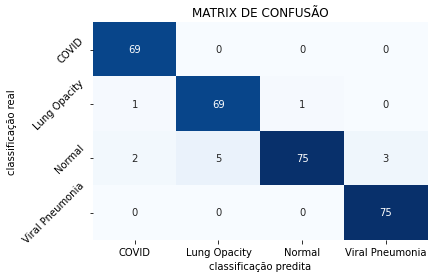

In [35]:
# rotina de treino e validacao
l_epoca, l_loss, l_acc = routine_train_validate(model, l_labels, ds_train, ds_val, 15, criterion, optimizer)

In [36]:
torch.save(model, name_model+'.pth')

In [37]:
l_metrics = []
l_metrics.append(l_loss)
l_metrics.append(l_acc)
l_names = ['val_loss', 'val_acc']
save_data_json('./', name_model, 'Data', l_metrics, l_names)

{'efficientnet_b1': {'val_acc': [0.9111842105263158,
   0.9243421052631579,
   0.9407894736842105,
   0.9473684210526315,
   0.9473684210526315,
   0.944078947368421,
   0.9473684210526315,
   0.9506578947368421,
   0.9572368421052632,
   0.9506578947368421,
   0.9506578947368421,
   0.944078947368421,
   0.9605263157894737,
   0.9506578947368421,
   0.9605263157894737],
  'val_loss': [0.26233815842945324,
   0.20891535885043835,
   0.16284183638268396,
   0.15849489565497557,
   0.13812631514462592,
   0.1463858697526647,
   0.14424702097772082,
   0.1581615421026455,
   0.13363359414353526,
   0.14748785614440413,
   0.13701673601080025,
   0.1516407653413664,
   0.12786340490167372,
   0.14066363125120437,
   0.137491261139267]},
 'efficientnet_b2': {'val_acc': [0.8881578947368421,
   0.9144736842105263,
   0.9342105263157895,
   0.9605263157894737,
   0.9407894736842105,
   0.9605263157894737,
   0.9539473684210527,
   0.9506578947368421,
   0.9473684210526315,
   0.953947368421052

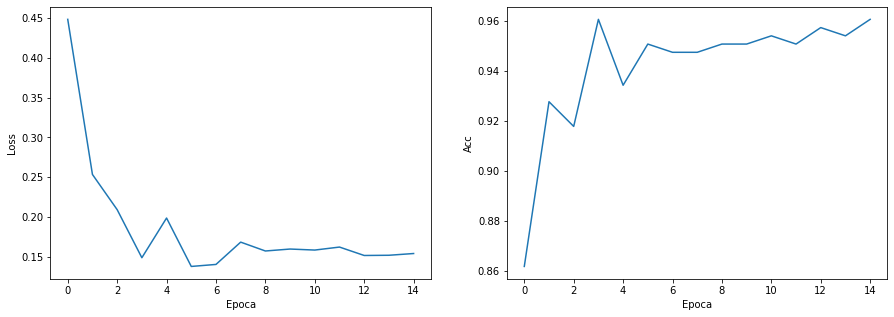

<Figure size 432x288 with 0 Axes>

In [38]:
plot_acc_loss(name_model, l_epoca, l_loss, l_acc)

Teste

  0%|          | 0/38 [00:00<?, ?it/s]

Accuracy Teste:    0.9506578947368421
Recall Score:      0.9490505108926162
Precission Score:  0.9523267707002647
F1:                0.9498696446809654
Loss Teste:        0.1716425124284701


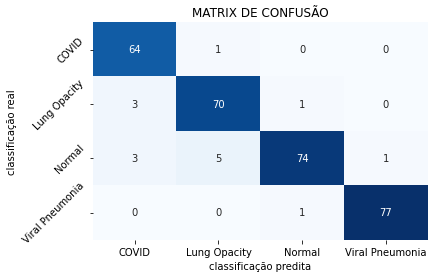

In [39]:
view_test(model, ds_test, criterion, name_model, l_labels)

##EfficientNet_b7

In [52]:
name_model = 'efficientnet_b7'
model = torchvision.models.efficientnet_b7(pretrained=True)
criterion = nn.CrossEntropyLoss().to(args['device'])
optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=0.9)

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-dcc49843.pth


  0%|          | 0.00/255M [00:00<?, ?B/s]

In [53]:
model.classifier[1] = nn.Linear(2560,4)

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:2/15.. Train Loss: 0.828.. Val Loss: 0.393.. Val Acc:0.878.. Val Prec:0.896.. Val Rec:0.874.. Time: 1.71m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:3/15.. Train Loss: 0.308.. Val Loss: 0.155.. Val Acc:0.938.. Val Prec:0.940.. Val Rec:0.936.. Time: 1.77m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:4/15.. Train Loss: 0.147.. Val Loss: 0.119.. Val Acc:0.954.. Val Prec:0.955.. Val Rec:0.953.. Time: 1.79m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:5/15.. Train Loss: 0.082.. Val Loss: 0.121.. Val Acc:0.954.. Val Prec:0.955.. Val Rec:0.954.. Time: 1.79m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:6/15.. Train Loss: 0.051.. Val Loss: 0.106.. Val Acc:0.957.. Val Prec:0.959.. Val Rec:0.957.. Time: 1.79m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:7/15.. Train Loss: 0.044.. Val Loss: 0.094.. Val Acc:0.967.. Val Prec:0.967.. Val Rec:0.966.. Time: 1.79m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:8/15.. Train Loss: 0.030.. Val Loss: 0.120.. Val Acc:0.961.. Val Prec:0.961.. Val Rec:0.960.. Time: 1.79m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:9/15.. Train Loss: 0.029.. Val Loss: 0.136.. Val Acc:0.954.. Val Prec:0.955.. Val Rec:0.954.. Time: 1.78m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:10/15.. Train Loss: 0.021.. Val Loss: 0.104.. Val Acc:0.970.. Val Prec:0.970.. Val Rec:0.970.. Time: 1.79m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:11/15.. Train Loss: 0.013.. Val Loss: 0.097.. Val Acc:0.964.. Val Prec:0.963.. Val Rec:0.964.. Time: 1.79m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:12/15.. Train Loss: 0.010.. Val Loss: 0.113.. Val Acc:0.957.. Val Prec:0.957.. Val Rec:0.957.. Time: 1.79m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:13/15.. Train Loss: 0.009.. Val Loss: 0.116.. Val Acc:0.961.. Val Prec:0.960.. Val Rec:0.960.. Time: 1.78m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:14/15.. Train Loss: 0.009.. Val Loss: 0.106.. Val Acc:0.961.. Val Prec:0.960.. Val Rec:0.960.. Time: 1.79m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:15/15.. Train Loss: 0.008.. Val Loss: 0.110.. Val Acc:0.970.. Val Prec:0.970.. Val Rec:0.970.. Time: 1.79m


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch:16/15.. Train Loss: 0.007.. Val Loss: 0.121.. Val Acc:0.970.. Val Prec:0.970.. Val Rec:0.970.. Time: 1.78m

---------------------------------------Final Results---------------------------------------
Mean:  {'Acc': 0.9543859649122811, 'Prec': 0.9558807024736928, 'Rec': 0.953649601018022, 'Loss': 0.13403340140618017}


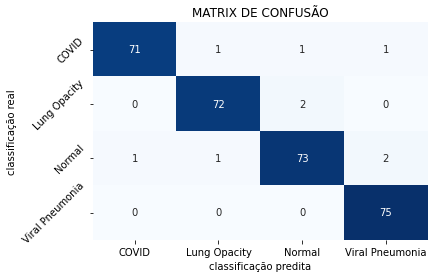

In [54]:
# rotina de treino e validacao
l_epoca, l_loss, l_acc = routine_train_validate(model, l_labels, ds_train, ds_val, 15, criterion, optimizer)

In [55]:
torch.save(model, name_model+'.pth')

In [56]:
l_metrics = []
l_metrics.append(l_loss)
l_metrics.append(l_acc)
l_names = ['val_loss', 'val_acc']
save_data_json('./', name_model, 'Data', l_metrics, l_names)

{'efficientnet_b1': {'val_acc': [0.9111842105263158,
   0.9243421052631579,
   0.9407894736842105,
   0.9473684210526315,
   0.9473684210526315,
   0.944078947368421,
   0.9473684210526315,
   0.9506578947368421,
   0.9572368421052632,
   0.9506578947368421,
   0.9506578947368421,
   0.944078947368421,
   0.9605263157894737,
   0.9506578947368421,
   0.9605263157894737],
  'val_loss': [0.26233815842945324,
   0.20891535885043835,
   0.16284183638268396,
   0.15849489565497557,
   0.13812631514462592,
   0.1463858697526647,
   0.14424702097772082,
   0.1581615421026455,
   0.13363359414353526,
   0.14748785614440413,
   0.13701673601080025,
   0.1516407653413664,
   0.12786340490167372,
   0.14066363125120437,
   0.137491261139267]},
 'efficientnet_b2': {'val_acc': [0.8881578947368421,
   0.9144736842105263,
   0.9342105263157895,
   0.9605263157894737,
   0.9407894736842105,
   0.9605263157894737,
   0.9539473684210527,
   0.9506578947368421,
   0.9473684210526315,
   0.953947368421052

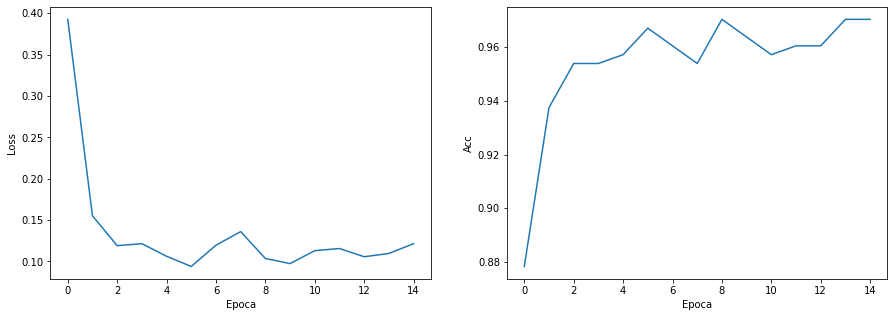

<Figure size 432x288 with 0 Axes>

In [57]:
plot_acc_loss(name_model, l_epoca, l_loss, l_acc)

Teste

  0%|          | 0/38 [00:00<?, ?it/s]

Accuracy Teste:    0.9572368421052632
Recall Score:      0.9566440138808561
Precission Score:  0.959023464458247
F1:                0.9569667199467771
Loss Teste:        0.16132285811870947


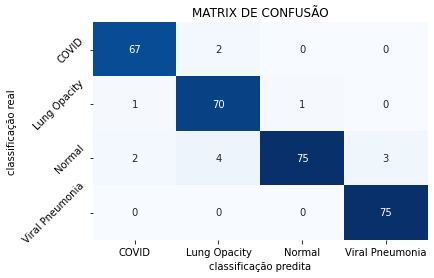

In [58]:
view_test(model, ds_test, criterion, name_model, l_labels)

#Comparativo visual dos resultados

In [59]:
f = open('Testes.json')
data_test = json.load(f)
print(data_test)

{'resnet18': {'test_loss': 0.2331777778224358, 'test_acc': 0.944078947368421}, 'resnet50': {'test_loss': 0.19711123497415284, 'test_acc': 0.9473684210526315}, 'resnet152': {'test_loss': 0.8817900039598738, 'test_acc': 0.7763157894736842}, 'resnext50': {'test_loss': 0.13849545325808177, 'test_acc': 0.9703947368421053}, 'efficientnet_b7': {'test_loss': 0.16132285811870947, 'test_acc': 0.9572368421052632}, 'efficientnet_b1': {'test_loss': 0.14398646474383944, 'test_acc': 0.9605263157894737}, 'efficientnet_b2': {'test_loss': 0.16100230293293288, 'test_acc': 0.9539473684210527}, 'efficientnet_b3': {'test_loss': 0.21442970147625984, 'test_acc': 0.9473684210526315}, 'efficientnet_b4': {'test_loss': 0.22373312925552263, 'test_acc': 0.9078947368421053}, 'efficientnet_b5': {'test_loss': 0.15931315662792736, 'test_acc': 0.9572368421052632}, 'efficientnet_b6': {'test_loss': 0.1716425124284701, 'test_acc': 0.9506578947368421}}


In [60]:
f = open('Data.json')
data_val = json.load(f)
print(data_val)

{'resnet18': {'val_loss': [0.38311372305217545, 0.257090326447628, 0.15202542784084616, 0.13327732046232804, 0.13708425088368945, 0.13901122053319245, 0.14036976329148992, 0.12806542169020854, 0.12423332193774465, 0.1228602283609737, 0.121844956351101, 0.12109310206754967, 0.12038958453922532, 0.1198610393475974, 0.11943852431738235], 'val_acc': [0.8717105263157895, 0.930921052631579, 0.9506578947368421, 0.9539473684210527, 0.9539473684210527, 0.9605263157894737, 0.9539473684210527, 0.9638157894736842, 0.9638157894736842, 0.9638157894736842, 0.9605263157894737, 0.9605263157894737, 0.9605263157894737, 0.9605263157894737, 0.9605263157894737]}, 'resnet50': {'val_acc': [0.7532894736842105, 0.9342105263157895, 0.9078947368421053, 0.9572368421052632, 0.944078947368421, 0.9703947368421053, 0.9638157894736842, 0.9671052631578947, 0.9703947368421053, 0.9671052631578947, 0.9671052631578947, 0.9671052631578947, 0.9671052631578947, 0.9671052631578947, 0.9671052631578947], 'val_loss': [0.7650746491

In [42]:
import pandas as pd

In [61]:
epoch = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
l_acc = [epoch, data_val['resnet18']['val_acc'], data_val['resnet50']['val_acc'],
         data_val['resnet152']['val_acc'], data_val['resnext50']['val_acc'], 
         data_val['resnext101']['val_acc'], data_val['efficientnet_b1']['val_acc'],
         data_val['efficientnet_b2']['val_acc'], data_val['efficientnet_b3']['val_acc'],
         data_val['efficientnet_b4']['val_acc'], data_val['efficientnet_b5']['val_acc'],
         data_val['efficientnet_b6']['val_acc'], data_val['efficientnet_b7']['val_acc']]
df = pd.DataFrame (l_acc).transpose()
df.columns = ['Epoch','ResNet18', 'ResNet50', 'ResNet152', 'ResNext50', 'ResNext101', 'EfficientNet B1',
              'EfficientNet B2', 'EfficientNet B3', 'EfficientNet B4', 'EfficientNet B5',
              'EfficientNet B6','EfficientNet B7']

In [62]:
import plotly.express as px
figura = px.line(title = 'Comparativo de redes')
for i in df.columns[1:]:
  figura.add_scatter(x = df['Epoch'], y = df[i], name = i)
figura.update_layout(xaxis_title='Epoch', yaxis_title='Val Accuracy')
figura.show()

#GRAD-CAM

In [21]:
model = torch.load('efficientnet_b1.pth', map_location = torch.device("cuda" if torch.cuda.is_available() else "cpu"))

In [28]:
l_imgs = [['Normal/Normal-1158.png', 'COVID/COVID-1106.png', 'Lung_Opacity/Lung_Opacity-143.png', 'Viral Pneumonia/Viral Pneumonia-233.png'],
          ['Normal/Normal-1233.png', 'COVID/COVID-1109.png', 'Lung_Opacity/Lung_Opacity-1144.png', 'Viral Pneumonia/Viral Pneumonia-169.png'],
          ['Normal/Normal-115.png', 'COVID/COVID-1394.png', 'Lung_Opacity/Lung_Opacity-1263.png', 'Viral Pneumonia/Viral Pneumonia-1083.png']]

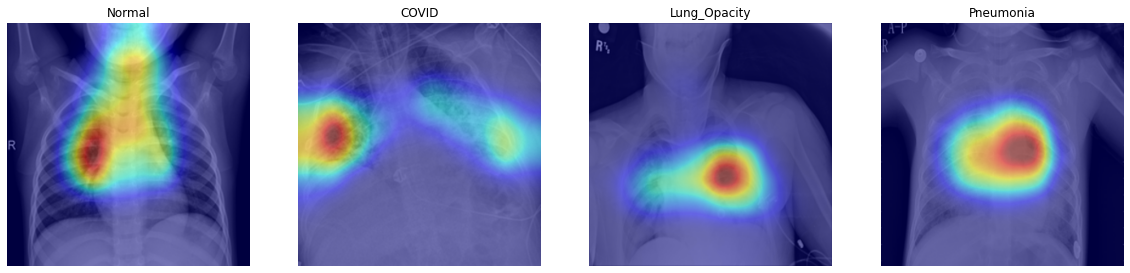

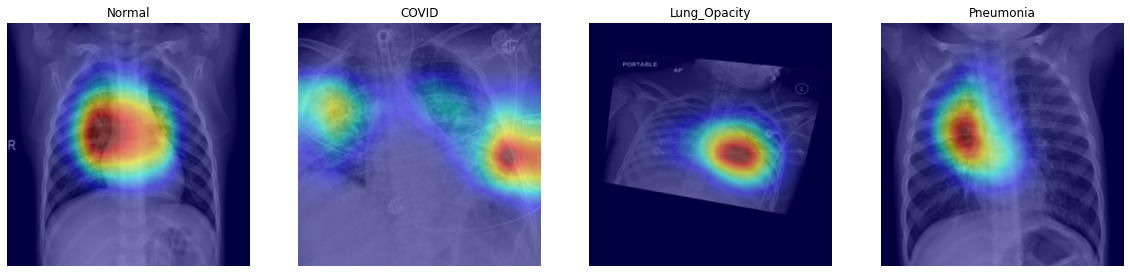

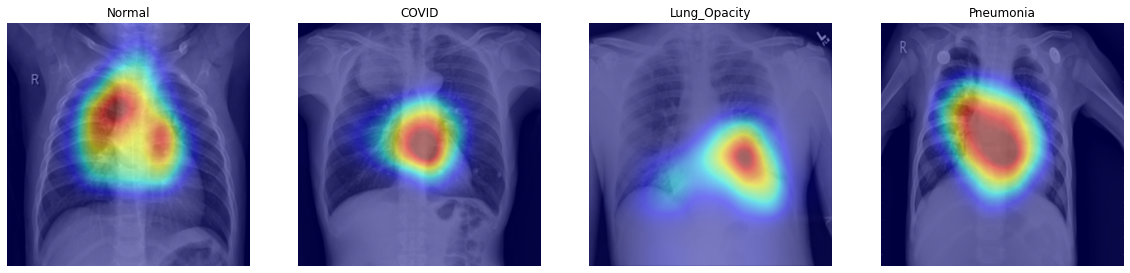

In [29]:
for l in l_imgs:

  fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20,10))
  ax1.imshow(grad_cam_img(model, transform, l[0], 'features.8'))
  ax1.set_title('Normal');
  ax1.set_axis_off()

  ax2.imshow(grad_cam_img(model, transform, l[1], 'features.8'))
  ax2.set_title('COVID')
  ax2.set_axis_off()

  ax3.imshow(grad_cam_img(model, transform, l[2], 'features.8'))
  ax3.set_title('Lung_Opacity')
  ax3.set_axis_off()

  ax4.imshow(grad_cam_img(model, transform, l[3], 'features.8'))
  ax4.set_title('Pneumonia')
  ax4.set_axis_off()